# Mesh tutorial 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argiope as ag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from string import Template
%matplotlib nbagg

## Geometry setup


In [3]:
geom_template = """
lc = $lc;
Point(1) = {0,0,0,lc};
Point(2) = {.5,0,0,lc};
Point(3) = {.5,.5,0,lc};
Point(4) = {1,.5,0,lc};
Point(5) = {1,1,0,lc};
Point(6) = {0,1,0,lc};
Point(7) = {.5,.25,0,lc};
Point(8) = {.5,.75,0,lc};
Point(9) = {.125,.875,0,lc};
Point(10) = {.125,.875-.05,0,lc};
Point(11) = {.125,.875+.05,0,lc};

Line(1)  = {1,2};
Circle(2)  = {2,3,4};
Line(3)  = {4,5};
Line(4)  = {5,6};
Line(5)  = {6,1};
Circle(6)  = {7,3,8};
Circle(7)  = {8,3,7};
Circle(8)  = {10,9,11};
Circle(9)  = {11,9,10};

Line Loop(1) = {6,7}; // interior loop
Line Loop(2) = {1,2,3,4,5}; // exterior loop
Line Loop(3) = {8,9};// hole
Plane Surface(2) = {2,1,3}; // exterior surface (with a hole)
Recombine Surface {2};
Physical Surface("SURFACE") = {2};
"""
open("./_workdir/mesh.geo", "w").write(Template(geom_template).substitute(lc = 0.025))

725

## Mesh creation

GMSH can be run directly as a shell command.

In [4]:
!gmsh -2 ./_workdir/mesh.geo -algo 'delquad' 

Info    : Running 'gmsh -2 ./_workdir/mesh.geo -algo delquad' [Gmsh 2.10.1, 1 node, max. 1 thread]
Info    : Started on Tue Jan  9 11:29:41 2018
Info    : Reading './_workdir/mesh.geo'...
Info    : Done reading './_workdir/mesh.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Circle)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Line)
Info    : Meshing curve 6 (Circle)
Info    : Meshing curve 7 (Circle)
Info    : Meshing curve 8 (Circle)
Info    : Meshing curve 9 (Circle)
Info    : Done meshing 1D (0 s)
Info    : Meshing 2D...
Info    : Meshing surface 2 (Plane, Frontal Quad)
Info    : Blossom: 3661 internal 232 closed
Info    : BEFORE OPTIMIZATION :  1259 quads     0 triangles    2 invalid quads   14 quads with Q < 0.1 Avg Q =  8.36104E-01 Min -1.36604E-01
Info    : IN OPTIMIZATION :  1244 quads     0 triangles    0 invalid quads    0 quads with Q < 0.1 Avg Q =  8.81967E-01 Min  4.14368E-01
Info    

It is even simpler to use the dedicated function in *argiope.utils*. 

In [5]:
ag.utils.run_gmsh(gmsh_path = "gmsh", 
                  gmsh_space = 2, 
                  gmsh_options = "-algo 'del2d'", 
                  name = "./_workdir/mesh.geo")

## Mesh reading

In [6]:
mesh = ag.mesh.read_msh("./_workdir/mesh.msh")
mesh.nodes.head()

coords          
          x    y    z
node                 
1       0.0  0.0  0.0
2       0.5  0.0  0.0
3       1.0  0.5  0.0
4       1.0  1.0  0.0
5       0.0  1.0  0.0

In [7]:
mesh.elements.head()

conn                  materials    sets    type       
           n0    n1   n2    n3           SURFACE argiope solver
                                                               
element                                                        
1         428  1655  762   761              True   quad4       
2         344   739  689  1513              True   quad4       
3         426   856  237   695              True   quad4       
4        1366   809  255  1227              True   quad4       
5         864   675  438  1446              True   quad4

## Putting it all together

Let's now do all these operations in a single function and do fun stuff.

In [8]:
def make_mesh(lc, algorithm = "del2d"):
    """
    A mesh function that creates a mesh.
    """
    open("./_workdir/mesh.geo", "w").write(Template(geom_template).substitute(lc = lc))
    ag.utils.run_gmsh(gmsh_path = "gmsh", 
                  gmsh_space = 2, 
                  gmsh_options = "-algo '{0}'".format(algorithm), 
                  name = "./_workdir/mesh.geo")
    mesh = ag.mesh.read_msh("./_workdir/mesh.msh")
    return mesh

mesh = make_mesh(0.02, "meshadapt")
mesh    

<Mesh, 2350 nodes, 2208 elements, 0 fields>

<IPython.core.display.Javascript object>


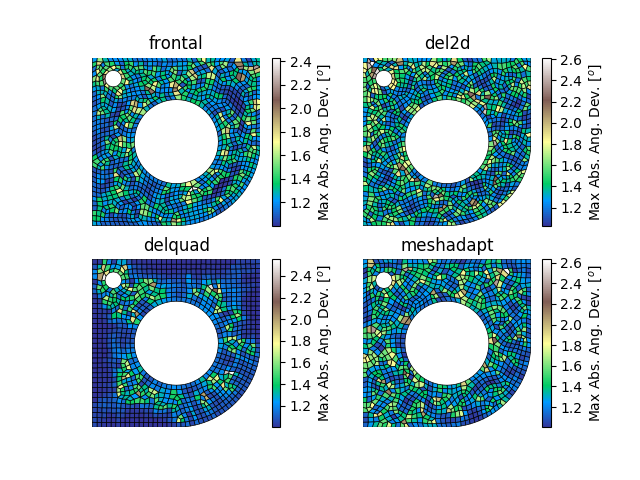

In [11]:
fig = plt.figure()
algos = ["frontal", "del2d", "delquad", "meshadapt"]
for i in range(len(algos)):
    mesh = make_mesh(0.03, algos[i])
    patches = mesh.to_polycollection(edgecolor = "black", linewidth = .5, alpha = 1.)
    stats = mesh.stats()
    #patches.set_array( stats.stats.max_abs_angular_deviation )
    patches.set_array( stats.stats.aspect_ratio )
    patches.set_cmap(mpl.cm.terrain)
    ax = fig.add_subplot(2, 2, i+1)
    ax.set_aspect("equal")
    ax.set_xlim(mesh.nodes.coords.x.min(), mesh.nodes.coords.x.max())
    ax.set_ylim(mesh.nodes.coords.y.min(), mesh.nodes.coords.y.max())
    ax.add_collection(patches)
    cbar = plt.colorbar(patches, orientation = "vertical")
    cbar.set_label("Max Abs. Ang. Dev. [$^o$]")
    ax.set_title(algos[i])
    #plt.xlabel("$x$")
    #plt.ylabel("$y$")
    #plt.grid()
    ax.axis('off')
plt.show()

## Mesh quality investigation

For example, let's investigate the effect of the mesh algorithm on the overall quality of the mesh.

In [10]:
stats = mesh.stats()
stats.stats.describe().loc[["min", "max", "mean", "std"]][["max_angular_deviation", "aspect_ratio"]]


,max_angular_deviation,aspect_ratio
min,0.812189,1.005641
max,57.488325,2.633344
mean,21.067222,1.342344
std,11.070150,0.234528
